<a href="https://colab.research.google.com/github/87tana/YOLOv8-Bone-Fracture-Detection-Model/blob/main/EDA_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

in this notebook, i assess the label distribution, bounding box statistic, image dimension and data quality

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)


# Navigate to the project directory
%cd '/content/drive/MyDrive/Project_Experiments/Bone_Fraction_Detection/'


# Define dataset path
dataset_path = '/content/drive/MyDrive/Project_Experiments/Bone_Fraction_Detection/Fraction_Detection_Dataset'

Mounted at /content/drive/
/content/drive/MyDrive/Project_Experiments/Bone_Fraction_Detection


In [64]:
# Install necessary libraries
!pip install -q ultralytics torch torchvision opencv-python pillow matplotlib tqdm
!pip install tabulate

In [3]:
# Import required libraries
import os
import random
import pandas as pd
import numpy as np

from sklearn.cluster import KMeans
import cv2

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

from tqdm import tqdm

from ultralytics import YOLO




In [4]:
# Set dataset paths
dataset_path = '/content/drive/MyDrive/Project_Experiments/Bone_Fraction_Detection/Fraction_Detection_Dataset'

train_images_dir = os.path.join(dataset_path, 'train/images')
train_labels_dir = os.path.join(dataset_path, 'train/labels')

validation_images_dir = os.path.join(dataset_path, 'valid/images')
validation_labels_dir = os.path.join(dataset_path, 'valid/labels')

test_images_dir = os.path.join(dataset_path, 'test/images')
test_labels_dir = os.path.join(dataset_path, 'test/labels')

In [5]:
#----------------------------------------------------------------------Train Dataset----------------------------------------------------------------

# list comprehensions to create a list for storing train images and labels respectively
train_image_files = sorted([f for f in os.listdir(train_images_dir) if f.endswith('.jpg')])
train_label_files = sorted([f for f in os.listdir(train_labels_dir) if f.endswith('.txt')])


# Check if the number of images and labels match, ensure neither are empty, and verify consistency between image-label pairs.

if len(train_image_files) != len(train_label_files):
    print("Warning: Number of images and labels do not match.")
else:
    print("Train Dataset is consistent.")

# Quick summary of train set
print(f"Number of train images: {len(train_image_files)}")
print(f"Number of train labels: {len(train_label_files)}")

Train Dataset is consistent.
Number of train images: 3779
Number of train labels: 3779


In [6]:
# ---------------------------------------------------------------------Valid Dataset----------------------------------------------------------------------------
# list comprehensions to create a list for storing valid images and labels respectively
validation_image_files = sorted([f for f in os.listdir(validation_images_dir) if f.endswith('.jpg')])
validation_label_files = sorted([f for f in os.listdir(validation_labels_dir) if f.endswith('.txt')])


# Check if the number of images and labels match, ensure neither are empty, and verify consistency between image-label pairs.

if len(validation_image_files) != len(validation_label_files):
    print("Warning: Number of images and labels do not match.")
else:
    print("Validation Dataset is consistent.")

# Quick summary of train set
print(f"Number of validation images: {len(validation_image_files)}")
print(f"Number of validation labels: {len(validation_label_files)}")

Validation Dataset is consistent.
Number of validation images: 835
Number of validation labels: 835


In [7]:
#----------------------------------------------------------------------- Test Dataset-----------------------------------------------------------------------------

# list comprehensions to create a list for storing valid images and labels respectively
test_image_files = sorted([f for f in os.listdir(test_images_dir) if f.endswith(('.jpg','.png'))])
test_label_files = sorted([f for f in os.listdir(test_labels_dir) if f.endswith('.txt')])


# Check if the number of images and labels match, ensure neither are empty, and verify consistency between image-label pairs.

if len(test_image_files) != len(test_label_files):
    print("Warning: Number of images and labels do not match.")
else:
    print("test Dataset is consistent.")

# Quick summary of train set
print(f"Number of test images: {len(test_image_files)}")
print(f"Number of test labels: {len(test_label_files)}")

test Dataset is consistent.
Number of test images: 841
Number of test labels: 841


# Extract File name, image(H,W), bbx(h,w), Number of bbx

In [15]:
def parse_annotations(labels_dir, images_dir):
    """
    Extracts: file name, image(W,H), bbx(W,H), Number of bbx
    Input: label_dir and image_dir
    Output: A list of dictionaries, each containing details about an image and its bounding boxes.
    """

    data = []

    for label_file in tqdm(os.listdir(labels_dir)):  # Iterate over annotation files
        label_path = os.path.join(labels_dir, label_file)
        image_path = os.path.join(images_dir, label_file.replace('.txt', '.jpg'))  # Get corresponding image

        # Get image dimensions
        img = cv2.imread(image_path)
        if img is None:
            continue  # Skip if image is missing
        img_height, img_width = img.shape[:2]

        # Parse label file and extract bounding box information
        bboxes = []
        with open(label_path, 'r') as f:
            for line in f:
                _, x_center, y_center, width, height = map(float, line.strip().split())  # Ignore class ID
                # Convert relative dimensions to absolute pixels
                bbox_width = width * img_width
                bbox_height = height * img_height
                bboxes.append([bbox_width, bbox_height])


        data.append({
            "file_name": label_file,
            "img_width": img_width,
            "img_height": img_height,
            "bboxes": bboxes,
            "num_bboxes": len(bboxes)
        })


    # Convert the data to a pandas DataFrame
    df = pd.DataFrame(data)
    return df


In [9]:
validation_images_dir = os.path.join(dataset_path, 'valid/images')
validation_labels_dir = os.path.join(dataset_path, 'valid/labels')

val_data = parse_annotations(validation_labels_dir,validation_images_dir )

100%|██████████| 835/835 [00:15<00:00, 55.02it/s]


In [11]:
# Display the DataFrame in a styled table format
display(val_data.head())

,file_name,img_width,img_height,bboxes,num_bboxes
0,images238_jpg.rf.e42be5127b183e6b62164f7f77022...,640,640,"[[171.5, 258.0], [271.5, 156.5]]",2
1,image2-17-_png.rf.f742020551425cb898e3eca29189...,640,640,"[[640.0, 620.0]]",1
2,image6_jpeg.rf.960a40c662df8be1faedb85435ddf5e...,640,640,"[[71.5, 145.5]]",1
3,image1-9-_png.rf.354c74a733a852c18c729641847b8...,640,640,"[[474.0, 608.0]]",1
4,images163_jpg.rf.b19125c2e0eb55815b487c54937cc...,640,640,"[[611.0, 615.0]]",1


In [12]:
test_images_dir = os.path.join(dataset_path, 'test/images')
test_labels_dir = os.path.join(dataset_path, 'test/labels')

test_data = parse_annotations(test_labels_dir,test_images_dir )

100%|██████████| 841/841 [00:15<00:00, 55.63it/s]


In [13]:
# Display the DataFrame in a styled table format
display(test_data.head())

,file_name,img_width,img_height,bboxes,num_bboxes
0,forearmpeds1_jpg.rf.5ece0d91646b1289554500c6ee...,640,640,"[[74.5, 130.5], [53.5, 100.5], [101.0, 210.0]]",3
1,image1-71-_png.rf.0fab732eb5d8c600e0d31fc9d38b...,640,640,"[[212.0, 452.0]]",1
2,image2-10-_png.rf.8cc9dd4467a54e95dc81858c06b7...,640,640,"[[183.0, 327.0]]",1
3,image1-79-_png.rf.1b9b09215ee237fc363b14a7f974...,640,640,"[[204.0, 503.0]]",1
4,image1-76-_png.rf.2cef027435c480d2aac5758f833e...,640,640,"[[183.5, 335.5], [121.0, 296.5], [143.0, 337.0]]",3


In [14]:
train_images_dir = os.path.join(dataset_path, 'train/images')
train_labels_dir = os.path.join(dataset_path, 'train/labels')

train_data = parse_annotations(train_labels_dir,train_images_dir )

100%|██████████| 3779/3779 [01:37<00:00, 38.77it/s]


In [22]:
# Display the DataFrame in a styled table format
display(train_data.tail())

,file_name,img_width,img_height,bbox_width,bbox_height,num_bboxes
4806,images526_jpg.rf.7d472c494943930cdfb078abda2b3...,640,640,135.0,99.5,NaN
4807,images526_jpg.rf.7d472c494943930cdfb078abda2b3...,640,640,85.0,58.5,NaN
4808,images526_jpg.rf.7d472c494943930cdfb078abda2b3...,640,640,45.5,67.0,NaN
4809,images531_jpg.rf.39888301e74bc76e33022d22e61e8...,640,640,0.0,0.0,0.0
4810,images554_jpg.rf.1ae932267e280ebf0ad20468ffcb7...,640,640,147.0,206.5,1.0


In [32]:
type(train_data)

pandas.core.frame.DataFrame

we want to do this 4 steps:

Extract Data: We'll extract bounding box sizes (width, height), image sizes, and calculate the diagonal.

Plot Histograms: First, we'll create histograms for the width and height for all subsets separately (train, validation, test).
Plot Diagonal Length: Then we'll plot histograms for the diagonal length for all subsets separately.
Clustering: Finally, we'll perform clustering on the bounding box sizes and visualize the clusters.

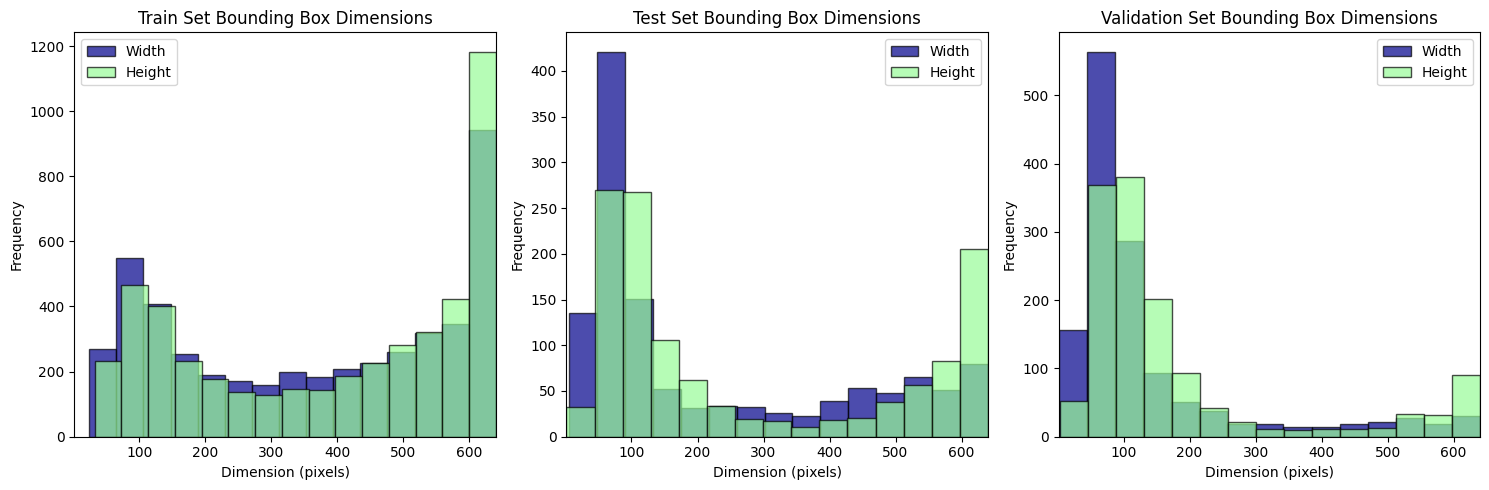

In [52]:
def plot_height_width_for_all_subsets(train_data, test_data, val_data):
    """
    Plots the height and width distributions for bounding boxes in the train, test, and validation subsets.

    Input:
    train_data, test_data, val_data: DataFrames containing parsed annotations for the respective subsets.
    """
    # Collect all the widths and heights for each subset
    train_widths = []
    train_heights = []
    test_widths = []
    test_heights = []
    val_widths = []
    val_heights = []

    for _, row in train_data.iterrows():
        for bbox in row['bboxes']:
            train_widths.append(bbox[0])
            train_heights.append(bbox[1])

    for _, row in test_data.iterrows():
        for bbox in row['bboxes']:
            test_widths.append(bbox[0])
            test_heights.append(bbox[1])

    for _, row in val_data.iterrows():
        for bbox in row['bboxes']:
            val_widths.append(bbox[0])
            val_heights.append(bbox[1])

    # Determine the common range for x-axis (dimension in pixels) based on min and max of all widths and heights
    min_dimension = min(min(train_widths), min(train_heights), min(test_widths), min(test_heights), min(val_widths), min(val_heights))
    max_dimension = max(max(train_widths), max(train_heights), max(test_widths), max(test_heights), max(val_widths), max(val_heights))

    # Plot histograms for the width and height distributions
    plt.figure(figsize=(15, 5))  # Adjust figure size for better comparability

    # Plot for train subset
    plt.subplot(1, 3, 1)
    plt.hist(train_widths, bins=15, alpha=0.7, label="Width", color='darkblue', edgecolor='black')
    plt.hist(train_heights, bins=15, alpha=0.7, label="Height", color='palegreen', edgecolor='black')
    plt.title('Train Set Bounding Box Dimensions')
    plt.xlabel('Dimension (pixels)')
    plt.ylabel('Frequency')
    plt.xlim(min_dimension, max_dimension)  # Use same x-axis limits for comparability
    plt.legend()

    # Plot for test subset
    plt.subplot(1, 3, 2)
    plt.hist(test_widths, bins=15, alpha=0.7, label="Width", color='darkblue', edgecolor='black')
    plt.hist(test_heights, bins=15, alpha=0.7, label="Height", color='palegreen', edgecolor='black')
    plt.title('Test Set Bounding Box Dimensions')
    plt.xlabel('Dimension (pixels)')
    plt.ylabel('Frequency')
    plt.xlim(min_dimension, max_dimension)  # Same x-axis limits for comparability
    plt.legend()

    # Plot for validation subset
    plt.subplot(1, 3, 3)
    plt.hist(val_widths, bins=15, alpha=0.7, label="Width", color='darkblue', edgecolor='black')
    plt.hist(val_heights, bins=15, alpha=0.7, label="Height", color='palegreen', edgecolor='black')
    plt.title('Validation Set Bounding Box Dimensions')
    plt.xlabel('Dimension (pixels)')
    plt.ylabel('Frequency')
    plt.xlim(min_dimension, max_dimension)  # Same x-axis limits for comparability
    plt.legend()

    plt.tight_layout()
    plt.show()


# Assuming train_data, test_data, and val_data are the DataFrames you get from parse_annotations for each subset.
plot_height_width_for_all_subsets(train_data, test_data, val_data)


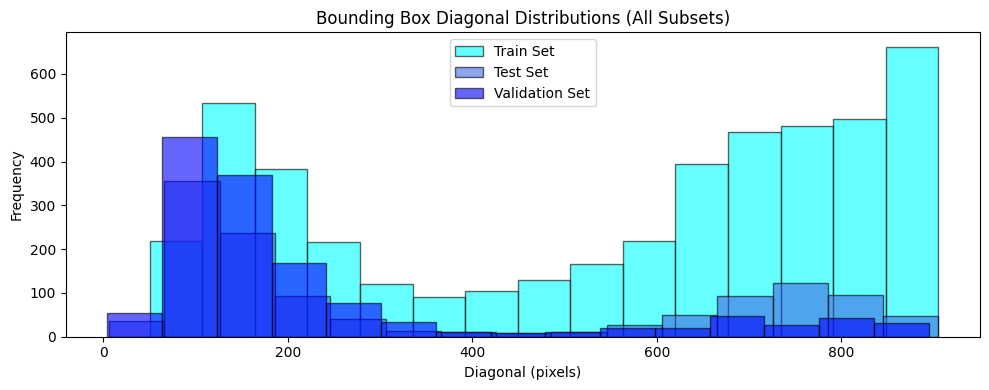

In [61]:
def plot_diagonal_for_all_subsets(train_data, test_data, val_data):
    """
    Plots the diagonal distributions for bounding boxes in the train, test, and validation subsets.

    Input:
    train_data, test_data, val_data: DataFrames containing parsed annotations for the respective subsets.
    """
    # Collect all the diagonals for each subset
    train_diagonals = []
    test_diagonals = []
    val_diagonals = []

    # Collect diagonals for the train set
    for _, row in train_data.iterrows():
        for bbox in row['bboxes']:
            # Calculate the diagonal for each bounding box
            diagonal = np.sqrt(bbox[0]**2 + bbox[1]**2)  # Pythagorean theorem
            train_diagonals.append(diagonal)

    # Collect diagonals for the test set
    for _, row in test_data.iterrows():
        for bbox in row['bboxes']:
            diagonal = np.sqrt(bbox[0]**2 + bbox[1]**2)
            test_diagonals.append(diagonal)

    # Collect diagonals for the validation set
    for _, row in val_data.iterrows():
        for bbox in row['bboxes']:
            diagonal = np.sqrt(bbox[0]**2 + bbox[1]**2)
            val_diagonals.append(diagonal)

    # Plot histograms for the diagonal distributions
    plt.figure(figsize=(10, 4))  # Adjust figure size for better comparability

    # Plot all subsets on the same plot
    plt.hist(train_diagonals, bins=15, alpha=0.6, color='aqua', edgecolor='black', label='Train Set')
    plt.hist(test_diagonals, bins=15, alpha=0.6, color='royalblue', edgecolor='black', label='Test Set')
    plt.hist(val_diagonals, bins=15, alpha=0.6, color='blue', edgecolor='black', label='Validation Set')

    # Adding titles and labels
    plt.title('Bounding Box Diagonal Distributions (All Subsets)')
    plt.xlabel('Diagonal (pixels)')
    plt.ylabel('Frequency')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Example Usage:
# Assuming train_data, test_data, and val_data are the DataFrames you get from parse_annotations for each subset.
plot_diagonal_for_all_subsets(train_data, test_data, val_data)


Train:
- A broad distribution with a peak around smaller diagonals (100–200 pixels).
- Includes a notable number of large diagonals, showing diversity in object sizes.

Test and validation:

- Sharper peaks at smaller diagonals, emphasizing that smaller bounding boxes dominate these subsets.
- Larger diagonals are less frequent than in the train set.

# KMeans Clustering on Bounding Box Sizes (Width, Height)

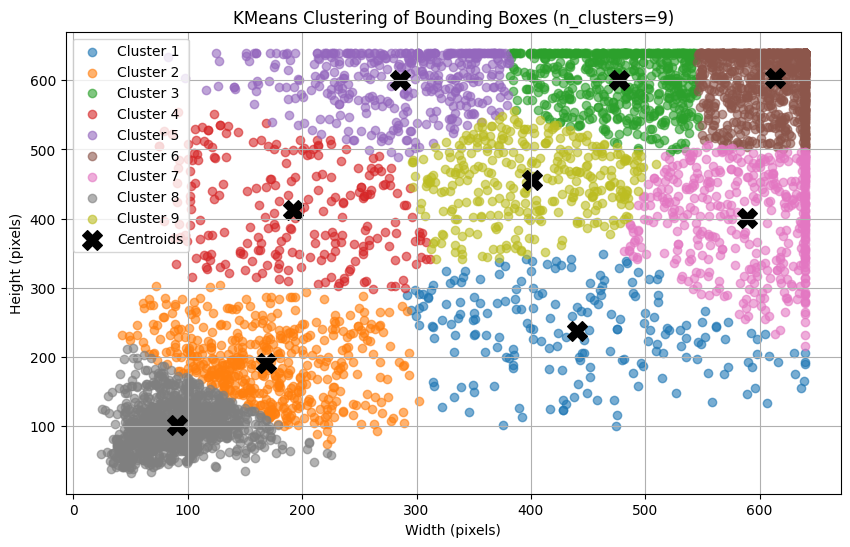

Cluster Centers (Width, Height):
[[        440      236.46]
 [     168.73       190.4]
 [     477.25      599.79]
 [     191.94      412.64]
 [     285.32      600.81]
 [     613.38      603.74]
 [     588.53      400.89]
 [     90.736      100.68]
 [     401.21      455.95]]


In [62]:
def cluster_bounding_boxes(train_data, n_clusters=9):
    """
    Perform KMeans clustering on bounding box sizes (width, height) for the training set
    and visualize the results.

    Parameters:
    train_data: DataFrame containing the parsed annotations for the training set.
    n_clusters: Number of clusters for KMeans.
    """
    # Collect all bounding box widths and heights
    train_bboxes = []
    for _, row in train_data.iterrows():
        for bbox in row['bboxes']:
            train_bboxes.append(bbox)  # bbox = [width, height]

    train_bboxes = np.array(train_bboxes)

    # Perform KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(train_bboxes)
    cluster_centers = kmeans.cluster_centers_
    labels = kmeans.labels_

    # Plot the clusters
    plt.figure(figsize=(10, 6))
    for i in range(n_clusters):
        cluster_points = train_bboxes[labels == i]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {i+1}', alpha=0.6)

    # Plot cluster centers
    plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], color='black', marker='X', s=200, label='Centroids')
    plt.title(f"KMeans Clustering of Bounding Boxes (n_clusters={n_clusters})")
    plt.xlabel("Width (pixels)")
    plt.ylabel("Height (pixels)")
    plt.legend()
    plt.grid(True)
    plt.show()

    return cluster_centers

# Example Usage:
# Assuming train_data is the DataFrame you get from parse_annotations for the training set
n_clusters = 9  # You can adjust this based on the number of anchors you plan to use
cluster_centers = cluster_bounding_boxes(train_data, n_clusters=n_clusters)
print("Cluster Centers (Width, Height):")
print(cluster_centers)